In [1]:
# 設定超參數HyperParameters 
batch_size =  128
epochs = 20
image_size = 128
lr=0.01

imageGen = True

## 一、載入相關套件

In [2]:
import os
import cv2
import csv
import random
import time
import numpy as np
import pandas as pd
import matplotlib.image as mpimg # mpimg 用於讀取圖片
import matplotlib.pyplot as plt # plt 用於顯示圖片
import seaborn as sns

In [3]:
import tensorflow as tf

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import utils as np_utils
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Dense, Activation, Conv2DTranspose

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
# Print Start time
from datetime import datetime, timezone
import pytz

tpe = pytz.timezone('Asia/Taipei')
utc_start = datetime.now()
print("Start Time", tpe.fromutc(utc_start))

Start Time 2020-05-28 12:34:19.607564+08:00


## 製作標籤&資料集

In [6]:
from imgGen import imgGenFunc

In [7]:
flip = 0; rotate = 0
x_train, y_train = imgGenFunc(image_size, flip, rotate)

芒果圖片數量:  5600
x_l:  5600
y_l:  5600


## 建立Model

In [8]:
# ResNet50V2

In [9]:
model_resnet = ResNet50V2(weights='imagenet', include_top=False)

input = Input( shape=(image_size,image_size,3),name = 'image_input' )
output_conv = model_resnet(input)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94674944/94668760 [==============================] - 2s 0us/step


In [10]:
## 由於該問題是分 3 類，需要在最後修改 Dense(3)，softmax 代表 output 是機率  
#Add the fully-connected layers 
p = Flatten()(output_conv)
p = Dense(256,activation = 'relu')(p)
p = Dropout(0.2)(p)
p = Dense(3, activation='softmax', name='predictions')(p)

model = Model(inputs=input, outputs=p)

model_2 = Model(inputs=input, outputs=p)
model_3 = Model(inputs=input, outputs=p)
model_4 = Model(inputs=input, outputs=p)

In [11]:
adam = optimizers.Adam(lr=lr)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])


model_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

model_3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

model_4.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

## 訓練

In [12]:
# Model檔名設定
file_name = str(epochs)+'_'+str(batch_size)

In [13]:
# 加入EarlyStopping以及Tensorboard等回調函數
CB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
TB = keras.callbacks.TensorBoard(log_dir='./log'+"_"+file_name, histogram_freq=1)

In [14]:
### Start Training
history_1 = model.fit(
    x = x_train, 
    y = y_train, 
    batch_size = batch_size,
    shuffle=True,
    epochs = epochs,
    validation_split=0.1
)

Train on 5040 samples, validate on 560 samples
Epoch 1/20
5040/5040 [==============================] - 66s 13ms/sample - loss: 1.4289 - acc: 0.6177 - val_loss: 49.6070 - val_acc: 0.3304
Epoch 2/20
5040/5040 [==============================] - 34s 7ms/sample - loss: 0.5770 - acc: 0.7563 - val_loss: 1.8685 - val_acc: 0.5357
Epoch 3/20
5040/5040 [==============================] - 34s 7ms/sample - loss: 0.4618 - acc: 0.8016 - val_loss: 1.9768 - val_acc: 0.6089
Epoch 4/20
5040/5040 [==============================] - 34s 7ms/sample - loss: 0.3726 - acc: 0.8474 - val_loss: 1.5333 - val_acc: 0.6946
Epoch 5/20
5040/5040 [==============================] - 34s 7ms/sample - loss: 0.3259 - acc: 0.8688 - val_loss: 1.3714 - val_acc: 0.7143
Epoch 6/20
5040/5040 [==============================] - 34s 7ms/sample - loss: 0.2545 - acc: 0.9008 - val_loss: 1.2840 - val_acc: 0.7125
Epoch 7/20
5040/5040 [==============================] - 34s 7ms/sample - loss: 0.2366 - acc: 0.9048 - val_loss: 1.7387 - val_acc:

In [15]:
# Print Finish Training time
tpe = pytz.timezone('Asia/Taipei')
utc_finish = datetime.now()
print("Finish Training Time", tpe.fromutc(utc_finish))

difference = utc_finish-utc_start
seconds_in_day = 24 * 60 * 60
divmod(difference.days * seconds_in_day + difference.seconds, 60)

Finish Training Time 2020-05-28 12:49:51.693431+08:00


(15, 32)

## 繪製Model學習成效

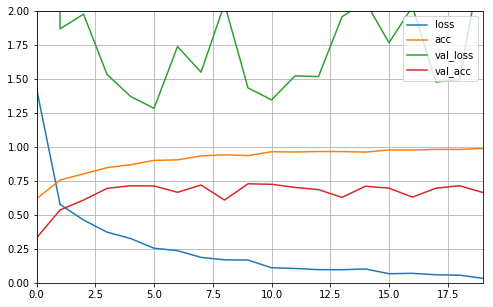

In [16]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2)
    plt.show()
    
plot_learning_curves(history_1)

## 測試集預測準確度

In [17]:
csvfile_test = open('dev.csv')
reader_test = csv.reader(csvfile_test)

In [18]:
# 讀取csv標籤
labels = []
for line in reader_test:
    tmp = [line[0],line[1]]
    # print tmp
    labels.append(tmp)
csvfile_test.close() 

In [19]:
labels = labels[1:]  # remove the first row
print("芒果圖片數量: ",len(labels))

芒果圖片數量:  800


In [20]:
# 轉換圖片的標籤
for i in range(len(labels)):
    labels[i][1] = labels[i][1].replace("A","0")
    labels[i][1] = labels[i][1].replace("B","1")
    labels[i][1] = labels[i][1].replace("C","2")

In [21]:
x_test = []
y_test = []

for i in range(len(labels)):
    img = cv2.imread("C1-P1_Dev/" + labels[i][0] )
    res = cv2.resize(img,(image_size,image_size),interpolation=cv2.INTER_LINEAR)
    res = img_to_array(res)
    x_test.append(res)    
    y_test.append(labels[i][1])

In [22]:
y_test_org = y_test

# 轉換至array的格式
x_test = np.array(x_test)
y_test = np.array(y_test)

In [23]:
# 轉換至float的格式
for i in range(len(x_test)):
    x_test[i] = x_test[i].astype('float32')
# x_test = x_test/255

In [24]:
# 標籤進行one-hotencoding
y_test = np_utils.to_categorical(y_test)

In [25]:
# 測試集標籤預測
y_pred = model.predict(x_test)

In [26]:
# 模型預測後的標籤
predict_label = np.argmax(y_pred,axis=1)
print(predict_label)
# print(len(predict_label))

[0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1
 0 0 0 0 2 0 0 1 1 2 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 2 1 1 2
 1 0 1 0 0 1 0 1 1 0 1 2 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 2 0
 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 2 0 1 1 0 0 0 1 0
 0 1 1 1 0 1 1 0 1 0 2 0 1 1 0 0 1 1 0 1 0 1 1 1 1 2 0 1 0 0 0 1 0 1 1 0 1
 1 0 0 1 1 1 2 1 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 2 1 1 1 1 1 1 2 0 0 1 1 0 0
 0 1 1 1 0 1 1 1 0 0 1 0 1 0 2 0 1 0 1 0 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 0 1 1 2 2 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 2
 1 1 1 1 2 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0
 1 1 0 1 0 2 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 2 0 1 1 1
 1 1 0 1 0 1 0 1 1 1 2 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0
 1 1 1 1 1 1 1 2 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 2 1 2 0 1 1 0 1 1 0
 1 1 0 0 1 1 1 1 1 1 1 1 

In [27]:
# 模型原標籤
true_label = y_test_org
true_label = np.array(true_label)
print(true_label)
# print(len(true_label))

['1' '0' '1' '1' '2' '1' '2' '0' '1' '0' '0' '1' '2' '1' '2' '1' '1' '0'
 '0' '1' '0' '0' '2' '0' '1' '0' '2' '2' '1' '1' '1' '0' '2' '2' '0' '0'
 '0' '0' '0' '0' '1' '2' '0' '2' '2' '2' '1' '0' '2' '0' '1' '1' '1' '2'
 '2' '0' '1' '0' '2' '0' '1' '1' '2' '0' '1' '2' '2' '0' '2' '1' '2' '1'
 '1' '2' '2' '2' '1' '0' '2' '0' '0' '2' '1' '1' '2' '2' '2' '2' '0' '1'
 '2' '2' '1' '2' '2' '2' '1' '0' '2' '2' '2' '1' '1' '2' '1' '1' '1' '1'
 '1' '2' '2' '0' '1' '0' '0' '2' '2' '0' '2' '0' '1' '0' '2' '1' '2' '1'
 '0' '1' '2' '1' '0' '0' '0' '1' '0' '2' '1' '1' '0' '2' '0' '1' '2' '0'
 '0' '0' '2' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '0' '2' '1' '2' '1'
 '0' '1' '2' '2' '1' '2' '0' '2' '1' '2' '2' '2' '2' '1' '0' '0' '0' '1'
 '2' '2' '0' '2' '1' '2' '0' '0' '2' '1' '2' '2' '1' '1' '2' '1' '0' '2'
 '1' '0' '2' '2' '1' '0' '1' '2' '0' '1' '2' '2' '2' '1' '1' '2' '0' '2'
 '1' '2' '1' '1' '0' '1' '1' '1' '1' '1' '0' '0' '1' '1' '0' '2' '1' '1'
 '0' '1' '2' '0' '2' '0' '1' '2' '2' '0' '1' '0' '2

In [28]:
pd.crosstab(true_label,predict_label,rownames=['實際值'],colnames=['預測值'])

預測值,0,1,2
實際值,,,
0,160,83,0
1,81,208,4
2,64,171,29


In [29]:
# 整體準確度
count = 0
for i in range(len(y_pred)):
    if(np.argmax(y_pred[i]) == np.argmax(y_test[i])): #argmax函数找到最大值的索引，即为其类别
        count += 1
score = count/len(y_pred)
print('正确率为:%.2f%s' % (score*100,'%'))

正确率为:49.62%


In [30]:
# 儲存模型相關參數
# model.save('h5/'+file_name+'.h5')

## Test 2

In [31]:
flip = 0; rotate = 1
x_train, y_train = imgGenFunc(image_size, flip, rotate)

芒果圖片數量:  5600
x_l:  16800
y_l:  16800


In [32]:
# Print Start time
from datetime import datetime, timezone
import pytz

tpe = pytz.timezone('Asia/Taipei')
utc_start = datetime.now()
print("Start Time", tpe.fromutc(utc_start))

Start Time 2020-05-28 12:51:39.563197+08:00


In [33]:
### Start Training
history_2 = model_2.fit(
    x = x_train, 
    y = y_train, 
    batch_size = batch_size,
    shuffle=True,
    epochs = epochs,
    validation_split=0.1
)

Train on 15120 samples, validate on 1680 samples
Epoch 1/20
15120/15120 [==============================] - 110s 7ms/sample - loss: 0.5890 - acc: 0.7576 - val_loss: 558.6382 - val_acc: 0.3899
Epoch 2/20
15120/15120 [==============================] - 103s 7ms/sample - loss: 0.4824 - acc: 0.7918 - val_loss: 0.6663 - val_acc: 0.7649
Epoch 3/20
15120/15120 [==============================] - 103s 7ms/sample - loss: 0.9074 - acc: 0.6974 - val_loss: 4363493288.2286 - val_acc: 0.3399
Epoch 4/20
15120/15120 [==============================] - 103s 7ms/sample - loss: 1.0631 - acc: 0.5132 - val_loss: 5.6285 - val_acc: 0.4440
Epoch 5/20
15120/15120 [==============================] - 103s 7ms/sample - loss: 0.8859 - acc: 0.5602 - val_loss: 1.1827 - val_acc: 0.5274
Epoch 6/20
15120/15120 [==============================] - 103s 7ms/sample - loss: 0.8874 - acc: 0.5794 - val_loss: 1.0578 - val_acc: 0.5548
Epoch 7/20
15120/15120 [==============================] - 103s 7ms/sample - loss: 0.8038 - acc: 0.62

In [34]:
# Print Finish Training time
tpe = pytz.timezone('Asia/Taipei')
utc_finish = datetime.now()
print("Finish Training Time", tpe.fromutc(utc_finish))

difference = utc_finish-utc_start
seconds_in_day = 24 * 60 * 60
divmod(difference.days * seconds_in_day + difference.seconds, 60)

Finish Training Time 2020-05-28 13:26:17.372900+08:00


(34, 37)

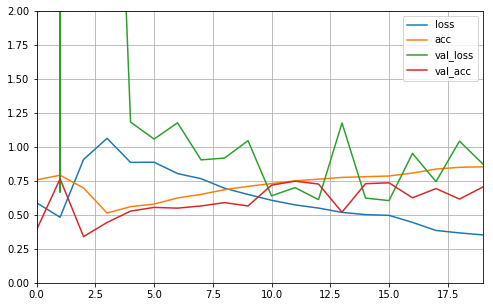

In [35]:
plot_learning_curves(history_2)

In [36]:
# 測試集標籤預測
y_pred = model_2.predict(x_test)

In [37]:
# 模型預測後的標籤
predict_label = np.argmax(y_pred,axis=1)
print(predict_label)
# print(len(predict_label))

[1 1 1 1 2 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 2 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 0 1 1 2 1 1 0 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [38]:
pd.crosstab(true_label,predict_label,rownames=['實際值'],colnames=['預測值'])

預測值,0,1,2
實際值,,,
0,14,227,2
1,13,265,15
2,1,238,25


In [39]:
# 整體準確度
count = 0
for i in range(len(y_pred)):
    if(np.argmax(y_pred[i]) == np.argmax(y_test[i])): #argmax函数找到最大值的索引，即为其类别
        count += 1
score = count/len(y_pred)
print('正确率为:%.2f%s' % (score*100,'%'))

正确率为:38.00%


## Test 3

In [40]:
flip = 1; rotate = 0
x_train, y_train = imgGenFunc(image_size, flip, rotate)

芒果圖片數量:  5600
x_l:  22400
y_l:  22400


In [41]:
# Print Start time
from datetime import datetime, timezone
import pytz

tpe = pytz.timezone('Asia/Taipei')
utc_start = datetime.now()
print("Start Time", tpe.fromutc(utc_start))

Start Time 2020-05-28 13:27:33.725158+08:00


In [42]:
### Start Training
history_3 = model_3.fit(
    x = x_train, 
    y = y_train, 
    batch_size = batch_size,
    shuffle=True,
    epochs = epochs,
    validation_split=0.1
)

Train on 20160 samples, validate on 2240 samples
Epoch 1/20
20160/20160 [==============================] - 147s 7ms/sample - loss: 0.5596 - acc: 0.7521 - val_loss: 1.6296 - val_acc: 0.4857
Epoch 2/20
20160/20160 [==============================] - 136s 7ms/sample - loss: 0.5573 - acc: 0.7679 - val_loss: 17527.7808 - val_acc: 0.3330
Epoch 3/20
20160/20160 [==============================] - 136s 7ms/sample - loss: 0.5777 - acc: 0.7453 - val_loss: 0.8315 - val_acc: 0.6295
Epoch 4/20
20160/20160 [==============================] - 136s 7ms/sample - loss: 0.5132 - acc: 0.7834 - val_loss: 1.3188 - val_acc: 0.3741
Epoch 5/20
20160/20160 [==============================] - 136s 7ms/sample - loss: 0.5771 - acc: 0.7585 - val_loss: 0.6676 - val_acc: 0.6848
Epoch 6/20
20160/20160 [==============================] - 136s 7ms/sample - loss: 0.5118 - acc: 0.7860 - val_loss: 0.9736 - val_acc: 0.5384
Epoch 7/20
20160/20160 [==============================] - 136s 7ms/sample - loss: 0.4685 - acc: 0.7993 - va

In [43]:
# Print Finish Training time
tpe = pytz.timezone('Asia/Taipei')
utc_finish = datetime.now()
print("Finish Training Time", tpe.fromutc(utc_finish))

difference = utc_finish-utc_start
seconds_in_day = 24 * 60 * 60
divmod(difference.days * seconds_in_day + difference.seconds, 60)

Finish Training Time 2020-05-28 14:13:21.610753+08:00


(45, 47)

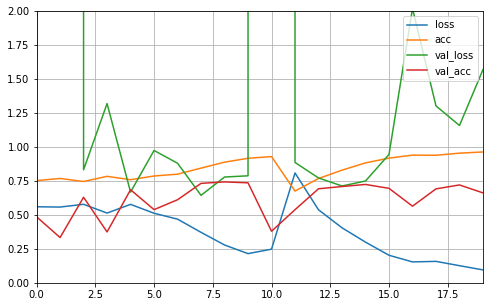

In [44]:
plot_learning_curves(history_3)

In [45]:
# 測試集標籤預測
y_pred = model_3.predict(x_test)

In [46]:
# 模型預測後的標籤
predict_label = np.argmax(y_pred,axis=1)
print(predict_label)
# print(len(predict_label))

[2 1 2 2 1 2 1 1 1 1 1 1 2 2 1 2 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 2 2 1 0 2 0
 0 0 1 0 2 0 1 2 1 2 2 2 1 2 2 1 1 2 1 1 1 2 2 2 1 1 0 1 1 1 1 0 1 2 1 2 2
 2 1 1 1 2 1 1 2 2 1 1 2 2 1 1 1 1 2 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 1 2 2 2
 2 2 1 1 1 1 2 2 1 1 1 1 2 2 1 1 2 2 1 1 0 1 1 2 0 1 2 1 2 1 1 2 0 1 1 2 2
 1 1 1 1 1 2 2 1 2 0 2 2 2 2 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 2 1 1 2 2 1 1 1
 1 2 1 1 2 2 1 2 1 1 2 0 1 1 0 2 1 1 1 1 0 0 1 2 1 1 1 2 1 1 2 2 1 1 2 1 1
 2 2 1 2 1 1 1 2 2 1 2 2 2 1 2 1 2 2 1 1 1 1 1 0 1 1 1 2 1 0 1 1 2 1 2 1 1
 2 1 1 2 2 1 2 2 1 2 1 2 2 1 2 1 1 2 2 2 1 1 1 2 2 2 1 2 2 1 1 1 2 1 2 2 0
 2 1 2 1 2 2 1 2 1 2 1 1 1 1 2 0 2 2 1 1 2 2 2 1 0 1 2 2 2 1 1 2 0 2 1 1 2
 1 1 2 2 2 1 2 2 0 1 2 0 1 1 2 1 2 1 1 1 0 1 2 1 1 2 0 1 1 1 1 1 1 2 1 1 0
 2 2 1 2 2 2 2 1 1 1 0 2 0 1 1 1 2 1 1 1 1 2 2 2 2 1 1 1 1 1 1 0 2 1 1 1 2
 2 1 1 1 1 1 0 1 1 1 2 2 2 2 1 2 1 0 1 2 2 1 2 1 2 2 1 2 2 1 1 1 1 2 1 1 1
 1 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 2 1 1 1 2 2 2 2 1 1 1 1 1 2 2
 2 1 1 1 1 1 1 1 1 1 2 1 

In [47]:
pd.crosstab(true_label,predict_label,rownames=['實際值'],colnames=['預測值'])

預測值,0,1,2
實際值,,,
0,40,150,53
1,7,168,118
2,7,141,116


In [48]:
# 整體準確度
count = 0
for i in range(len(y_pred)):
    if(np.argmax(y_pred[i]) == np.argmax(y_test[i])): #argmax函数找到最大值的索引，即为其类别
        count += 1
score = count/len(y_pred)
print('正确率为:%.2f%s' % (score*100,'%'))

正确率为:40.50%


## Test 4

In [49]:
flip = 1; rotate = 1
x_train, y_train = imgGenFunc(image_size, flip, rotate)

芒果圖片數量:  5600
x_l:  33600
y_l:  33600


In [50]:
# Print Start time
from datetime import datetime, timezone
import pytz

tpe = pytz.timezone('Asia/Taipei')
utc_start = datetime.now()
print("Start Time", tpe.fromutc(utc_start))

Start Time 2020-05-28 14:14:44.679425+08:00


In [51]:
### Start Training
history_4 = model_4.fit(
    x = x_train, 
    y = y_train, 
    batch_size = batch_size,
    shuffle=True,
    epochs = epochs,
    validation_split=0.1
)

Train on 30240 samples, validate on 3360 samples
Epoch 1/20
30240/30240 [==============================] - 213s 7ms/sample - loss: 0.3480 - acc: 0.8661 - val_loss: 0.4441 - val_acc: 0.8217
Epoch 2/20
30240/30240 [==============================] - 204s 7ms/sample - loss: 0.2755 - acc: 0.8939 - val_loss: 41.8634 - val_acc: 0.6872
Epoch 3/20
30240/30240 [==============================] - 205s 7ms/sample - loss: 0.2487 - acc: 0.9161 - val_loss: 0.7778 - val_acc: 0.7387
Epoch 4/20
30240/30240 [==============================] - 204s 7ms/sample - loss: 0.1395 - acc: 0.9502 - val_loss: 2.3746 - val_acc: 0.4530
Epoch 5/20
30240/30240 [==============================] - 205s 7ms/sample - loss: 0.1305 - acc: 0.9520 - val_loss: 0.7970 - val_acc: 0.7830
Epoch 6/20
30240/30240 [==============================] - 204s 7ms/sample - loss: 0.1727 - acc: 0.9341 - val_loss: 2.3188 - val_acc: 0.4789
Epoch 7/20
30240/30240 [==============================] - 204s 7ms/sample - loss: 0.2135 - acc: 0.9205 - val_l

In [52]:
# Print Finish Training time
tpe = pytz.timezone('Asia/Taipei')
utc_finish = datetime.now()
print("Finish Training Time", tpe.fromutc(utc_finish))

difference = utc_finish-utc_start
seconds_in_day = 24 * 60 * 60
divmod(difference.days * seconds_in_day + difference.seconds, 60)

Finish Training Time 2020-05-28 15:23:13.266460+08:00


(68, 28)

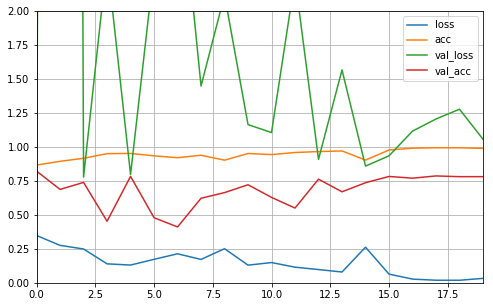

In [53]:
plot_learning_curves(history_4)

In [54]:
# 測試集標籤預測
y_pred = model_4.predict(x_test)

In [55]:
# 模型預測後的標籤
predict_label = np.argmax(y_pred,axis=1)
print(predict_label)
# print(len(predict_label))

[1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 0 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 0 0 1 1 2 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 2 1 1 1 1 2 0 1 1 1 1
 1 1 1 1 2 1 2 1 1 1 1 0 1 1 1 1 2 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 2 1 1 1 0 2 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 1 2 2 1 1 1 1 1 1 1 1 1 2 0 1 1 0 1 1 1 1 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 

In [56]:
pd.crosstab(true_label,predict_label,rownames=['實際值'],colnames=['預測值'])

預測值,0,1,2
實際值,,,
0,24,213,6
1,17,258,18
2,3,226,35


In [57]:
# 整體準確度
count = 0
for i in range(len(y_pred)):
    if(np.argmax(y_pred[i]) == np.argmax(y_test[i])): #argmax函数找到最大值的索引，即为其类别
        count += 1
score = count/len(y_pred)
print('正确率为:%.2f%s' % (score*100,'%'))

正确率为:39.62%
